## **Flow Matching for Gaussian CondOT Path**

This notebook trains a neural network to match the flow for the Gaussian CondOT path: $p_t(z \mid x) = \mathcal{N}(tz, (1 - t)^2)$

In [2]:
# Import libraries
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### **1. Define the Dataset**

We need a dataset of samples $z \sim p_{\text{data}}$.  For simplicity, let’s assume $p_{\text{data}}$ is a 1D Gaussian distribution, $\mathcal{N}(5, 1)$, centered at 5 with a standard deviation of 1.  In practice, this could be a more complex distribution (e.g., image data), but 1D makes visualization easier.

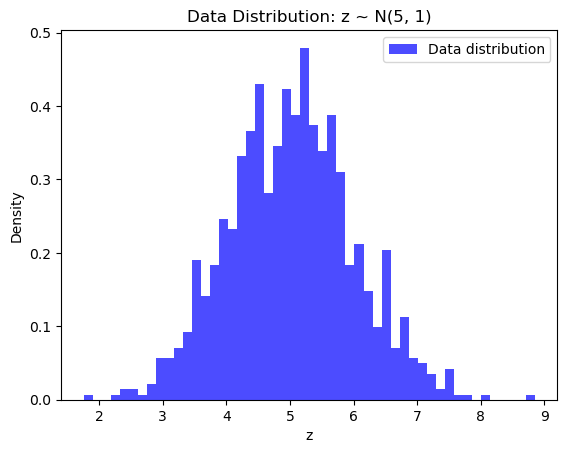

In [3]:
n_samples = 1000
z_data = np.random.normal(loc = 5.0, scale = 1.0, size = n_samples)

# Convert to PyTorch tensor
z_data = torch.tensor(z_data, dtype = torch.float32).to(device)

# Visualize the data distribution
plt.hist(z_data.cpu().numpy(), bins=50, density=True, alpha=0.7, color='blue', label='Data distribution')
plt.title("Data Distribution: z ~ N(5, 1)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()

### **2. Define the Neural Network**

We need a neural network $u_\theta(x, t)$ to approximate the vector field.  Since $x$ and $t$ are inputs, and we’re in 1D, the network takes a 2D input ($x$ and $t$) and outputs a 1D vector (the velocity). We’ll use a simple feedforward network with a few layers.

In [4]:
class VectorFieldNet(nn.Module): 
    def __init__(self, hidden_dim = 64): 
        super(VectorFieldNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, t): 
        # Concatenate x and t as input
        inputs = torch.cat([x.unsqueeze(-1), t.unsqueeze(-1)], dim = -1)
        return self.net(inputs)
    

model = VectorFieldNet().to(device)

### **3. Train the Neural Network**

In [ ]:
batch_size = 128
n_epochs = 5000 
learning_rate = 1e-3

# Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Lists to store losses for plotting
losses = [] 

# Training loop
for epoch in range(n_epochs): 
    # Step 1: sample a mini-batch of z 
    indices = np.random.choice(n_samples, batch_size)
    z = z_data[indices].unsqueeze(-1) # Shape: (batch_size, 1)

    # Step 2: Sample t ~ Unif [0, 1]
    t = torch.rand(batch_size, device = device) # Shape: (batch_size, )

    # Step 3: Sample noise epsilon ~ N(0, 1)
    epsilon = torch.randn(batch_size, 1, device = device) # Shape: (batch_size, 1)

    # Step 4: Compute x = t*z + (1-t)*epsilon
    x = t.unsqueeze(-1)*z + (1 - t.unsqueeze(-1) * epsilon) # Shape: (batch_size, 1)

    # step 5: Compute the target u_t(x|z) = z - epsilon
    target = z - epsilon # Shape: (batch_size, 1)

    # Step 6: Compute the model prediction u_theta(x, t)
    u_theta = model(x, t) # Shape: (batch_size, 1)

    # Step 7: Compute the loss
    loss = torch.mean((u_theta - target)**2)

    # Step 8: Backpropagation and optimization 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 

    # Store the loss
    losses.append(loss.item())

    # Print progress every 500 epochs 
    if (epoch + 1) % 500 == 0: 
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

In [ ]:
# Plot the training loss
plt.plot(losses, label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [5]:
z_data.shape

torch.Size([1000])